In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gmphd import mtt_phd
from utils import *

In [12]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 20

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

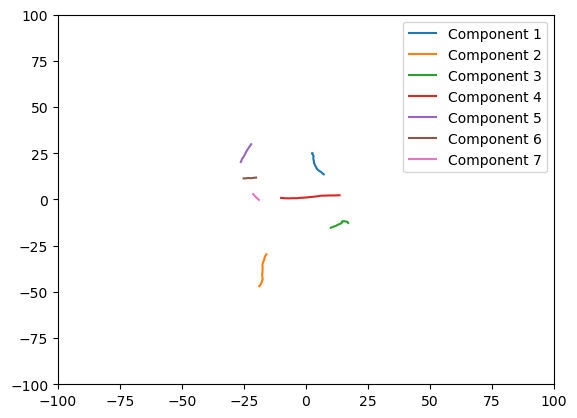

In [13]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.xlim(*area)
    plt.ylim(*area)
plt.legend()

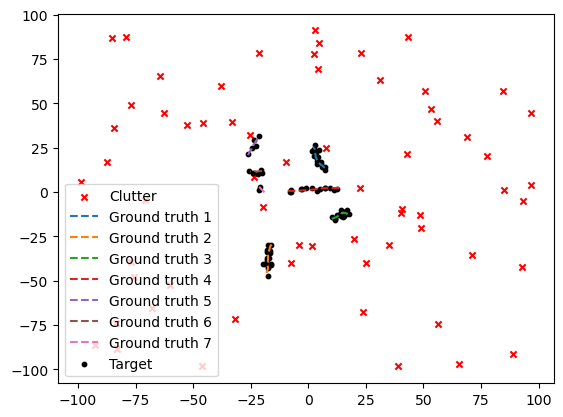

In [14]:
# generate measurements
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)
        else:
            plt.scatter(measurement[0], measurement[1], color='black', label=f'Target', s=10)
    
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [15]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [16]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1.0

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = init_truths.copy()
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [17]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[1.0, 1.0, 1.0]
Initial means:
[[  7.16888434  13.60843048  -0.71794575   0.60096023]
 [-15.94650205 -29.65542581  -0.42102107  -0.99414524]
 [ 17.03024471 -12.69333691  -0.35378676   0.36236617]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


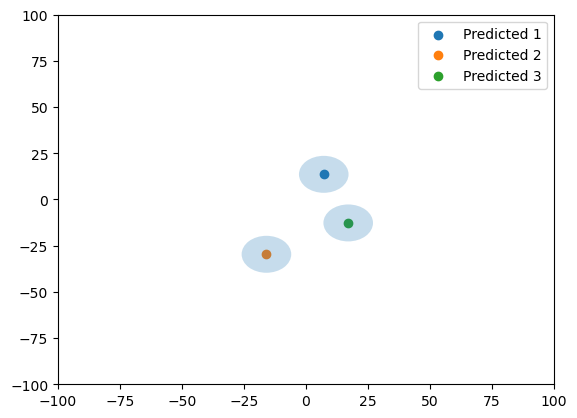

In [18]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)
plt.legend()

# Spawning

In [19]:
# initialize the filter
filter= mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/(area[1] - area[0])**2,
    merging_threshold = 5.0, # 5
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.7, # 0.607, # 0.60799
    new_birth_weight=0.25, # 0.25,
    spawning = True
)

history = filter.full_PHD_filter_run()

Prev pos: [-16.26091425 -29.863066  ], New pos: [-16.68188078 -30.85607399]
Prev pos: [ 7.26156706 12.72289895], New pos: [ 6.55191154 13.31841557]
Prev pos: [ 16.64876564 -10.65067786], New pos: [ 16.28306582 -10.28153256]
Prev pos: [-15.92041968 -29.2811247 ], New pos: [-16.22628631 -30.11557945]
Prev pos: [ 7.1808428  13.08167329], New pos: [ 6.46949875 13.67886233]
Prev pos: [ 16.67690088 -10.95403564], New pos: [ 16.31219272 -10.58537516]
Prev pos: [ 6.59420626 14.42955459], New pos: [ 5.47831097 15.59914085]
Prev pos: [ 39.94172616 -12.08181873], New pos: [ 39.58705183 -11.71887174]
Prev pos: [ 17.09593256 -14.88289357], New pos: [ 16.78396427 -16.01665868]
Prev pos: [59.32983873 11.02705608], New pos: [58.96413891 11.39620138]
Prev pos: [10.98570531 16.29646217], New pos: [10.27536112 16.89251165]
Prev pos: [ 65.25255012 -30.87034344], New pos: [ 64.8868503  -30.50119814]
Prev pos: [ 56.36674571 -22.35019411], New pos: [ 56.00104589 -21.98104881]
Prev pos: [ 16.35473491 -12.5174

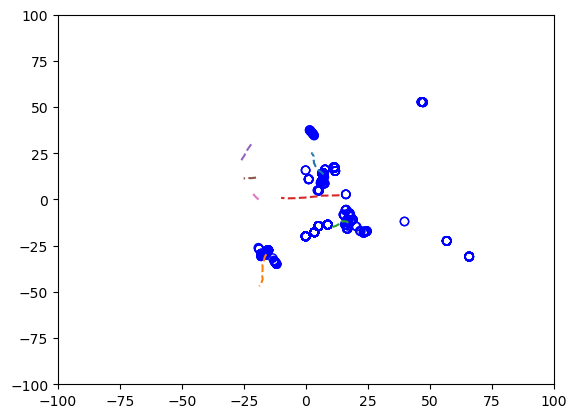

In [20]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')

# No Spawning

In [21]:
filter_nospawn = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/(area[1] - area[0])**2,
    merging_threshold = 5.0, # 5
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.7, # 0.607, # 0.60799
    new_birth_weight=0.25, # 0.25,
    spawning = False
)


history = filter_nospawn.full_PHD_filter_run()

Prev pos: [-16.26091425 -29.863066  ], New pos: [-16.68188078 -30.85607399]
Prev pos: [ 7.26156706 12.72289895], New pos: [ 6.55191154 13.31841557]
Prev pos: [ 16.64876564 -10.65067786], New pos: [ 16.28306582 -10.28153256]
Prev pos: [-15.89133086 -29.2628954 ], New pos: [-16.1947942  -30.09402216]
Prev pos: [ 7.03909319 13.13133505], New pos: [ 6.32793014 13.72834305]
Prev pos: [ 16.68051324 -10.95305046], New pos: [ 16.31549847 -10.58418746]
Prev pos: [ 6.59420626 14.42955459], New pos: [ 5.47831097 15.59914085]
Prev pos: [ 17.09593256 -14.88289357], New pos: [ 16.78396427 -16.01665868]
Prev pos: [59.32983873 11.02705608], New pos: [58.96413891 11.39620138]
Prev pos: [ 39.94172568 -12.08181937], New pos: [ 39.58705132 -11.71887305]
Prev pos: [29.46357202 13.92945663], New pos: [28.7539165  14.52497326]
Prev pos: [ 65.25255012 -30.87034344], New pos: [ 64.8868503  -30.50119814]
Prev pos: [ 16.35351115 -12.51910399], New pos: [ 15.99955218 -12.16021219]
Prev pos: [-17.99403497 -31.2158

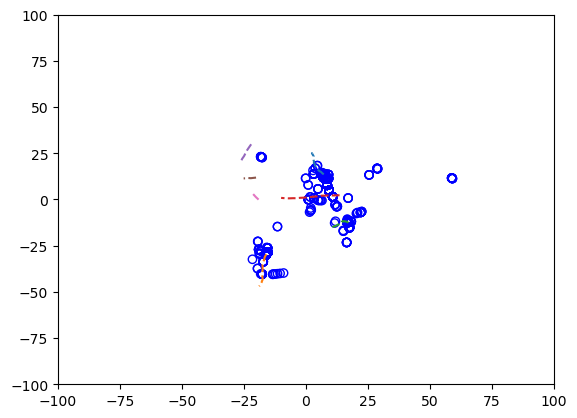

In [22]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')